** Import Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize
import seaborn as sns


**Simulate Vasicek Process**

In [2]:
def simulate_vasicek(k, theta, sigma, r0, T, N):
    dt = T / N
    rates = np.zeros(N + 1)
    rates[0] = r0
    for t in range(1, N + 1):
        Z = np.random.randn()
        rates[t] = rates[t - 1] + k * (theta - rates[t - 1]) * dt + sigma * np.sqrt(dt) * Z
    return rates


** OLS Estimation Function**

In [3]:
def ols_estimation(data, dt):
    X = data[:-1].reshape(-1, 1)
    Y = data[1:].reshape(-1, 1)

    model = LinearRegression().fit(X, Y)
    slope = model.coef_[0][0]
    intercept = model.intercept_[0]

    k = (1 - slope) / dt
    theta = intercept / (1 - slope)
    sigma = np.std(Y - model.predict(X)) / np.sqrt(dt)

    return k, theta, sigma


**Log-Likelihood Function**

In [4]:
def vasicek_log_likelihood(data, dt, k, theta, sigma):
    r_prev = data[:-1]
    r_next = data[1:]

    alpha = np.exp(-k * dt)
    beta = theta * (1 - alpha)
    variance = (sigma**2) / (2 * k) * (1 - np.exp(-2 * k * dt))

    ll = -0.5 * np.sum(np.log(2 * np.pi) + np.log(variance) + ((r_next - alpha * r_prev - beta) ** 2) / variance)
    return ll


** Negative Log-Likelihood Wrapper for MLE**

In [5]:
def neg_log_likelihood(params):
    k, theta, sigma = params
    return -vasicek_log_likelihood(data, dt, k, theta, sigma)


** Simulation and Estimation**

In [6]:
# True parameters
k_true, theta_true, sigma_true = 7, 0.05, 0.5
r0, T, N = 0.3, 1, 100
dt = T / N

# Simulate data
np.random.seed(123)
data = simulate_vasicek(k_true, theta_true, sigma_true, r0, T, N)

# Estimate using OLS
k_ols, theta_ols, sigma_ols = ols_estimation(data, dt)

# Estimate using MLE
initial_guess = [k_ols, theta_ols, sigma_ols]
result = minimize(neg_log_likelihood, initial_guess, method='Nelder-Mead')
k_mle, theta_mle, sigma_mle = result.x

# Print results
print(f"True:    k={k_true:.3f}, θ={theta_true:.3f}, σ={sigma_true:.3f}")
print(f"OLS:     k={k_ols:.3f}, θ={theta_ols:.3f}, σ={sigma_ols:.3f}")
print(f"MLE:     k={k_mle:.3f}, θ={theta_mle:.3f}, σ={sigma_mle:.3f}")


True:    k=7.000, θ=0.050, σ=0.500
OLS:     k=9.587, θ=0.080, σ=0.563
MLE:     k=10.079, θ=0.080, σ=0.592


** Line Plot of Simulated Vasicek Process**

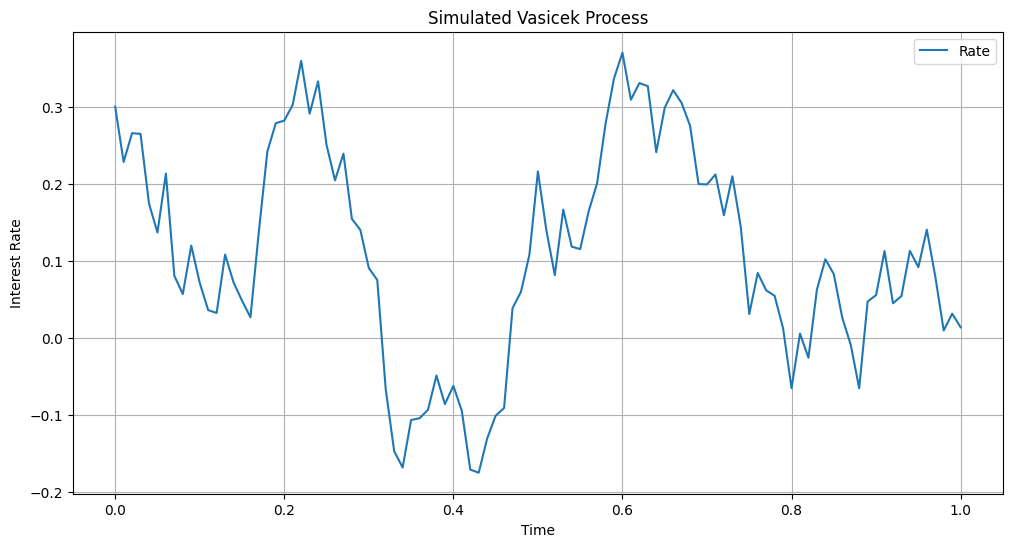

In [7]:
# Time series dataframe
df = pd.DataFrame({'Time': np.linspace(0, T, N+1), 'Rate': data})
df.set_index('Time', inplace=True)

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=df)
plt.title('Simulated Vasicek Process')
plt.xlabel('Time')
plt.ylabel('Interest Rate')
plt.grid(True)
plt.show()


**Likelihood Function for Different Parameters (3D Plots)**

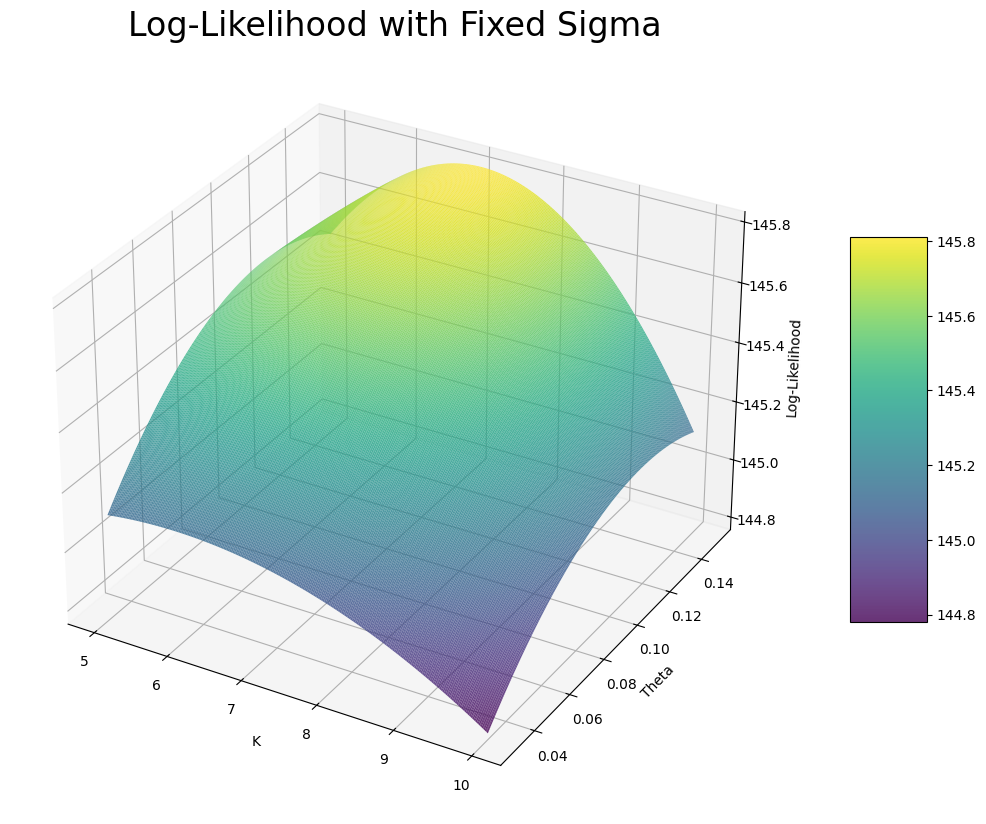

In [9]:
# Define ranges for the parameters
sigma_v = np.linspace(0.4, 0.6, 250)
k_v = np.linspace(5, 10, 250)
theta_v = np.linspace(0.03, 0.15, 250)

def plot_with_fixed_sigma(sigma_value):
    grid1, grid2 = np.meshgrid(k_v, theta_v)
    log_lik = np.zeros((250, 250))

    for i in range(250):
        for j in range(250):
            params = (k_v[i], theta_v[j], sigma_value)
            log_lik[i, j] = -neg_log_likelihood(params)

    fig = plt.figure(figsize=(18, 10))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(grid1, grid2, log_lik, cmap='viridis', rstride=1, cstride=1, alpha=0.8)
    ax.set_xlabel('K')
    ax.set_ylabel('Theta')
    ax.set_zlabel('Log-Likelihood')
    plt.title('Log-Likelihood with Fixed Sigma', fontsize=24)
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.show()

plot_with_fixed_sigma(sigma_mle)


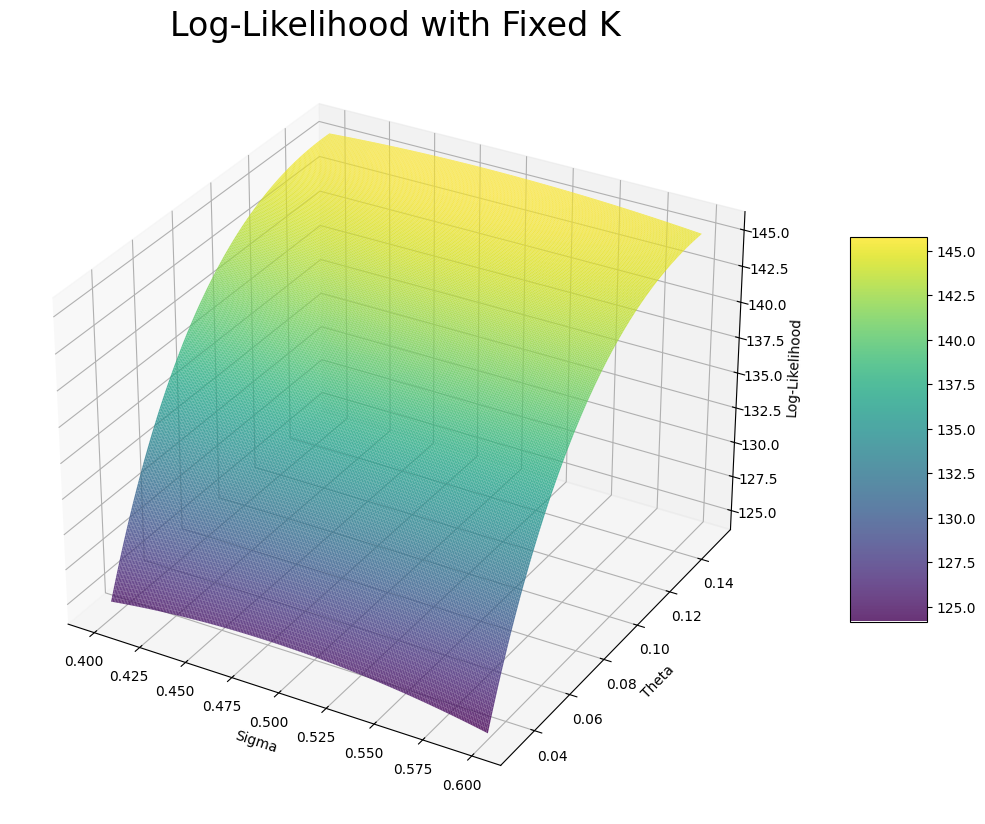

In [10]:
def plot_with_fixed_k(k_value):
    grid1, grid2 = np.meshgrid(sigma_v, theta_v)
    log_lik = np.zeros((250, 250))

    for i in range(250):
        for j in range(250):
            params = (k_value, theta_v[j], sigma_v[i])
            log_lik[i, j] = -neg_log_likelihood(params)

    fig = plt.figure(figsize=(18, 10))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(grid1, grid2, log_lik, cmap='viridis', rstride=1, cstride=1, alpha=0.8)
    ax.set_xlabel('Sigma')
    ax.set_ylabel('Theta')
    ax.set_zlabel('Log-Likelihood')
    plt.title('Log-Likelihood with Fixed K', fontsize=24)
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.show()

plot_with_fixed_k(k_mle)


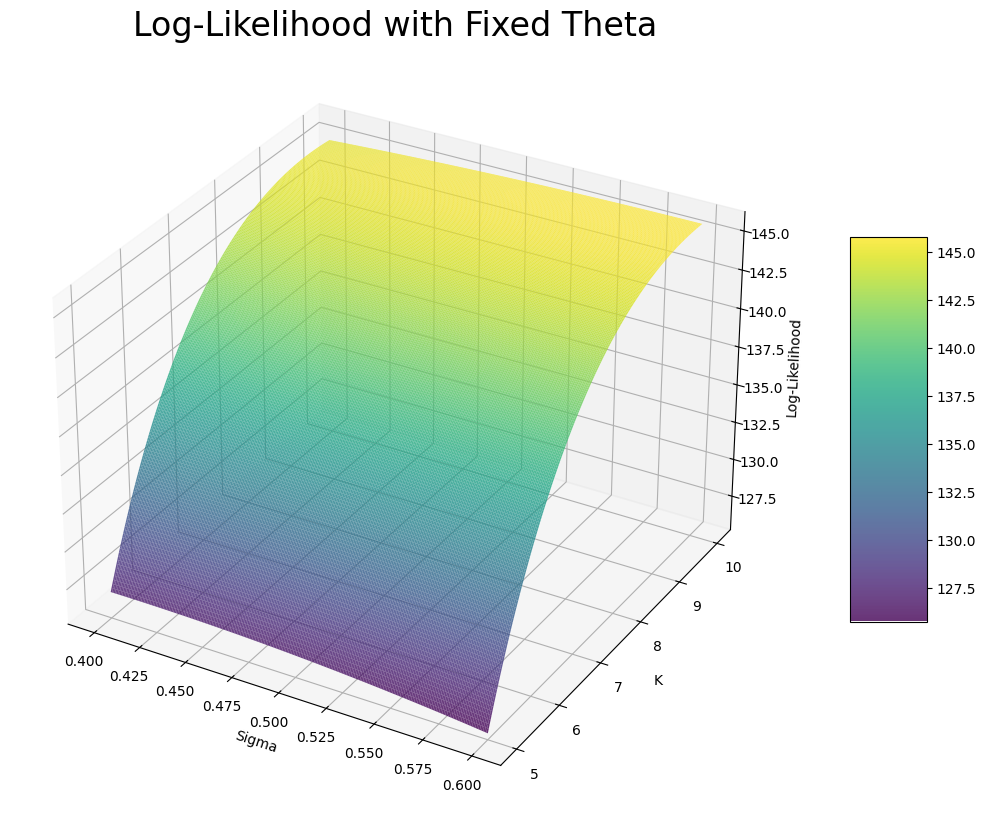

In [11]:
def plot_with_fixed_theta(theta_value):
    grid1, grid2 = np.meshgrid(sigma_v, k_v)
    log_lik = np.zeros((250, 250))

    for i in range(250):
        for j in range(250):
            params = (k_v[j], theta_value, sigma_v[i])
            log_lik[i, j] = -neg_log_likelihood(params)

    fig = plt.figure(figsize=(18, 10))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(grid1, grid2, log_lik, cmap='viridis', rstride=1, cstride=1, alpha=0.8)
    ax.set_xlabel('Sigma')
    ax.set_ylabel('K')
    ax.set_zlabel('Log-Likelihood')
    plt.title('Log-Likelihood with Fixed Theta', fontsize=24)
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.show()

plot_with_fixed_theta(theta_mle)


**Graph for Log-Likelihood with Different Theta Values**

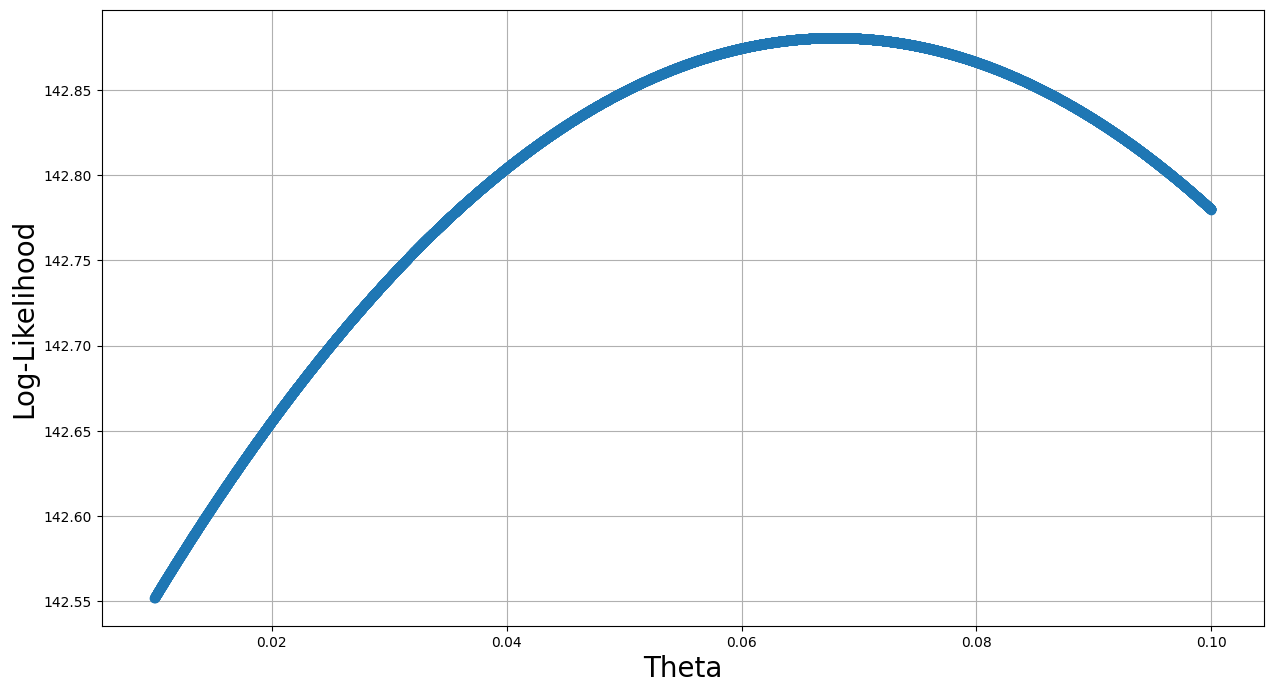

In [13]:
theta_v = np.linspace(0.01, 0.1, 10000)
likelihood = np.zeros(10000)

for n in range(len(theta_v)):
    params = (k_true, theta_v[n], sigma_true)
    # Replacing 'VASlog' with 'vasicek_log_likelihood'
    likelihood[n] = vasicek_log_likelihood(data, dt, params[0], params[1], params[2])

plt.figure(figsize=(15,8))
plt.plot(theta_v, likelihood, marker='o', linestyle='-')
plt.xlabel('Theta', fontsize=20)
plt.ylabel('Log-Likelihood', fontsize=20)
plt.grid(True)
plt.show()

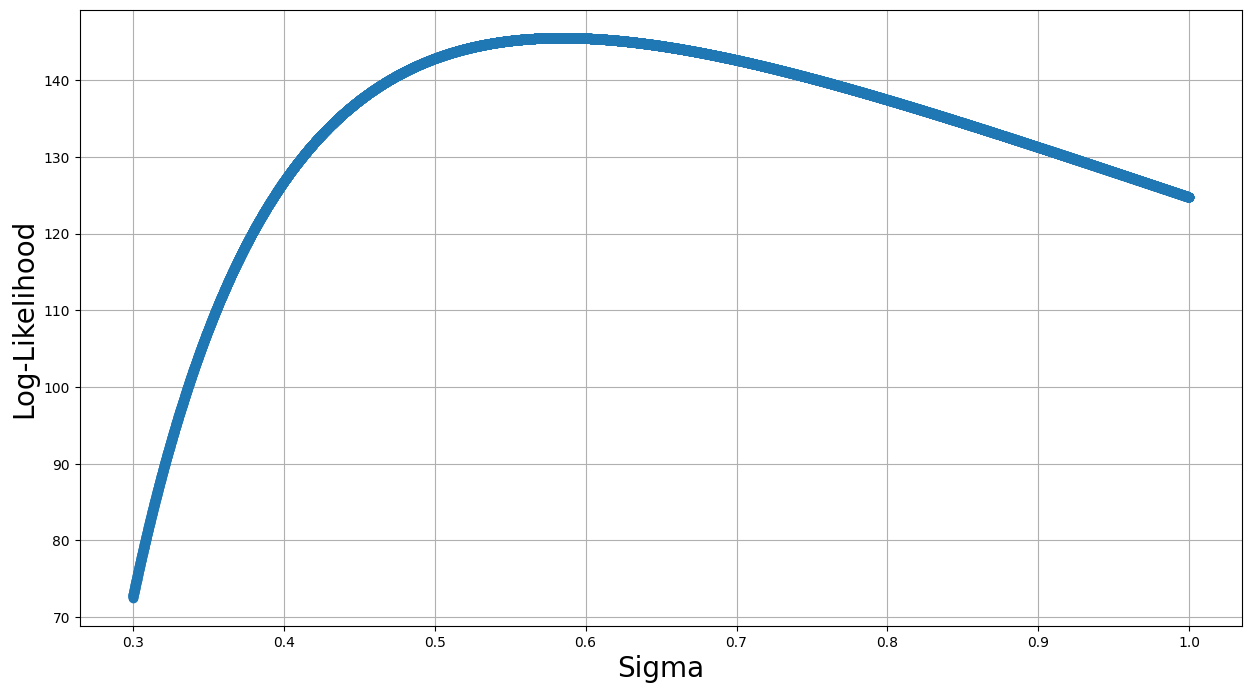

In [17]:
sigma_v = np.linspace(0.3, 1, 10000)
likelihood = np.zeros(10000)

for n in range(len(sigma_v)):
    params = (k_true, theta_true, sigma_v[n])
    # Replacing 'VASlog' with 'vasicek_log_likelihood'
    likelihood[n] = vasicek_log_likelihood(data, dt, params[0], params[1], params[2])

plt.figure(figsize=(15,8))
plt.plot(sigma_v, likelihood, marker='o', linestyle='-')
plt.xlabel('Sigma', fontsize=20)
plt.ylabel('Log-Likelihood', fontsize=20)
plt.grid(True)
plt.show()